In [1]:
import librosa, matplotlib.pyplot as plt, numpy as np, os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import load_model, Sequential
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

C:\Users\aniray\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len = 11):
    wave, sr = librosa.load(file_path, mono = True, sr = None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

def save_data_to_array(path, max_len = 11):
    labels, _, _ = get_labels(path)
    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

def get_train_test(path, split_ratio = 0.8):
    # Get available labels
    labels, indices, _ = get_labels(path)
    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])
    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
    assert X.shape[0] == len(y)
    return train_test_split(X, y, test_size= (1 - split_ratio), shuffle=True)

In [3]:
# Folder Path
DATA_PATH = "./data/"
num_classes = 30

# Save data to array file first
save_data_to_array(DATA_PATH, max_len = 11)

# Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test(DATA_PATH)

# one hot encoding
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

# Feature dimension
feature_dim_1 = 20
feature_dim_2 = 11
channel = 1

# Reshaping to perform 2D convolution
X_train_reshaped = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test_reshaped = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

# defining CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size = (2, 2), activation = 'relu', input_shape = (feature_dim_1, feature_dim_2, channel)))
model.add(Conv2D(64, kernel_size = (2, 2), activation = 'relu'))
model.add(Conv2D(128, kernel_size = (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.125))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

# Fit the model
checkpoint = ModelCheckpoint(filepath = 'model.h5', save_best_only = True, verbose = 1)
earlystop = EarlyStopping(min_delta = 0.001, patience = 5, verbose = 1)
history = model.fit(X_train_reshaped, y_train_hot, batch_size = 100, epochs = 100, validation_split = 0.25, callbacks = [checkpoint, earlystop], verbose = 0)

# evaluate the model
model = load_model('model.h5')
scores = model.evaluate(X_test_reshaped, y_test_hot, verbose = 0)

Saving vectors of label - 'zero': 100%|███████████████████████████████████████████| 2376/2376 [00:20<00:00, 117.00it/s]



Epoch 00001: val_loss improved from inf to 1.09154, saving model to model.h5

Epoch 00002: val_loss improved from 1.09154 to 0.83046, saving model to model.h5

Epoch 00003: val_loss improved from 0.83046 to 0.76888, saving model to model.h5

Epoch 00004: val_loss improved from 0.76888 to 0.67950, saving model to model.h5

Epoch 00005: val_loss did not improve from 0.67950

Epoch 00006: val_loss did not improve from 0.67950

Epoch 00007: val_loss did not improve from 0.67950

Epoch 00008: val_loss did not improve from 0.67950

Epoch 00009: val_loss did not improve from 0.67950
Epoch 00009: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 10, 32)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 9, 64)         8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 8, 128)        32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

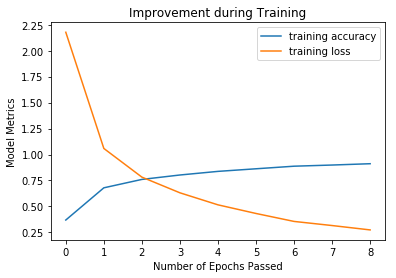

Model categorical_accuracy: 79.96%


In [4]:
# printing results
print(model.summary())
plot_model(model, to_file='cnn.png', show_shapes = True, show_layer_names = False)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['loss'])
plt.title('Improvement during Training')
plt.ylabel('Model Metrics')
plt.xlabel('Number of Epochs Passed')
plt.legend(['training accuracy', 'training loss'], loc = 'best')
plt.savefig('progress.png')
plt.show()
print("Model %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))